## BRAIN TUMOR DETECTOR

### import libraries

In [65]:
import tensorflow as tf

In [ ]:
import os
import glob
import hashlib
from pathlib import Path
from collections import Counter
import shutil

import numpy as np
import pandas as pd
from PIL import Image, ImageStat, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score

import warnings
warnings.filterwarnings('ignore')

try:
    import cv2
except:
    cv2 = None

try:
    import imagehash
except:
    imagehash = None

# Optional CNN embeddings
USE_CNN_EMBEDDINGS = False
try:
    if USE_CNN_EMBEDDINGS:
        import torch
        import torchvision.transforms as T
        import torchvision.models as models
except:
    USE_CNN_EMBEDDINGS = False

# Paths and config
DATA_DIR = "mri_dataset"  
OUT_DIR = "eda_outputs"
SAMPLE_PER_CLASS = 6
RANDOM_STATE = 42

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "plots"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "samples"), exist_ok=True)

### overview of dataset

In [12]:
def find_image_files(root):
    exts = ("*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff", "*.bmp")
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return sorted(paths)

def im_read_rgb(path, target_mode="RGB"):
    img = Image.open(path)
    img.load()
    return img.convert(target_mode)

# Scan dataset
image_paths = find_image_files(DATA_DIR)
print(f"Found {len(image_paths)} image files in total.\n")

# Label extraction (assuming folder name = class)
labels = [Path(p).parent.name for p in image_paths]
df_images = pd.DataFrame({"path": image_paths, "class": labels})

# Summary
class_counts = df_images["class"].value_counts()
print(f"Found {len(class_counts)} unique classes:\n")
for c, n in class_counts.items():
    print(f"{c}: {n} images")

# Preview dataframe
df_images.head()


Found 7023 image files in total.

Found 4 unique classes:

notumor: 2000 images
pituitary: 1757 images
meningioma: 1645 images
glioma: 1621 images


,path,class
0,mri_dataset\Testing\glioma\Te-glTr_0000.jpg,glioma
1,mri_dataset\Testing\glioma\Te-glTr_0001.jpg,glioma
2,mri_dataset\Testing\glioma\Te-glTr_0002.jpg,glioma
3,mri_dataset\Testing\glioma\Te-glTr_0003.jpg,glioma
4,mri_dataset\Testing\glioma\Te-glTr_0004.jpg,glioma


### Insight

There are 7023 images in this dataset with healthy brain MRI Images(notumor) having the largest number of images at 2000.



### sample of dataset

Color modes: {'L': 2340, 'RGB': 2905, 'RGBA': 3, 'P': 1}
Corrupted images: 0



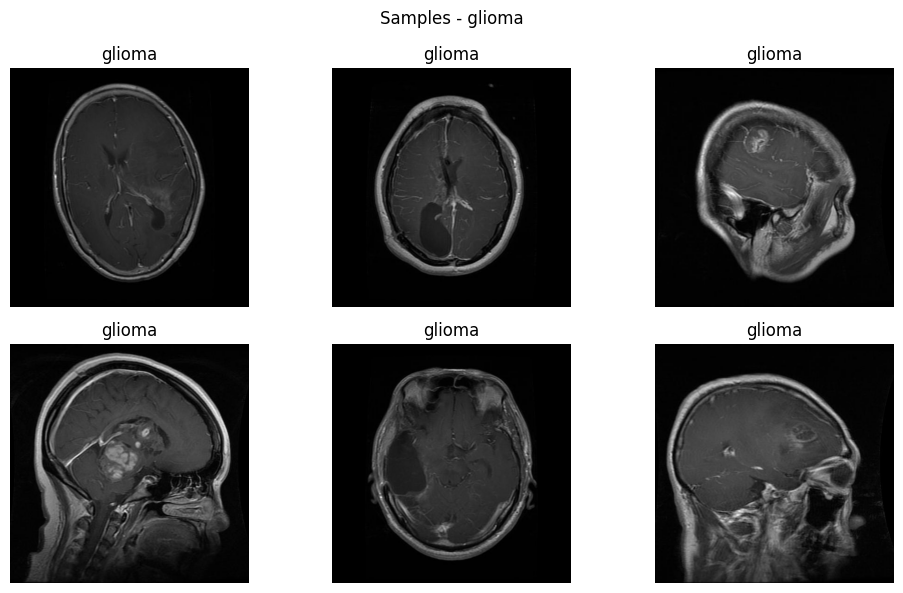

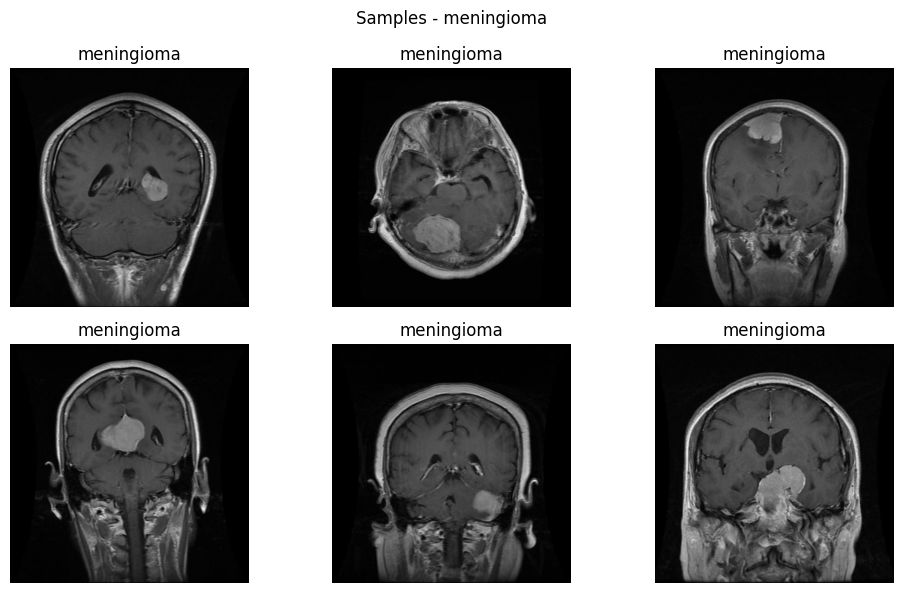

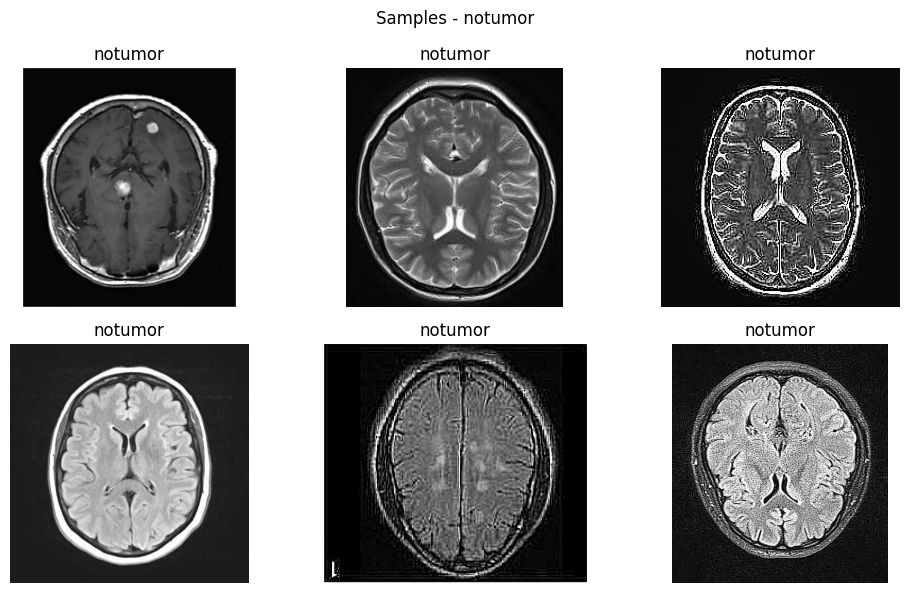

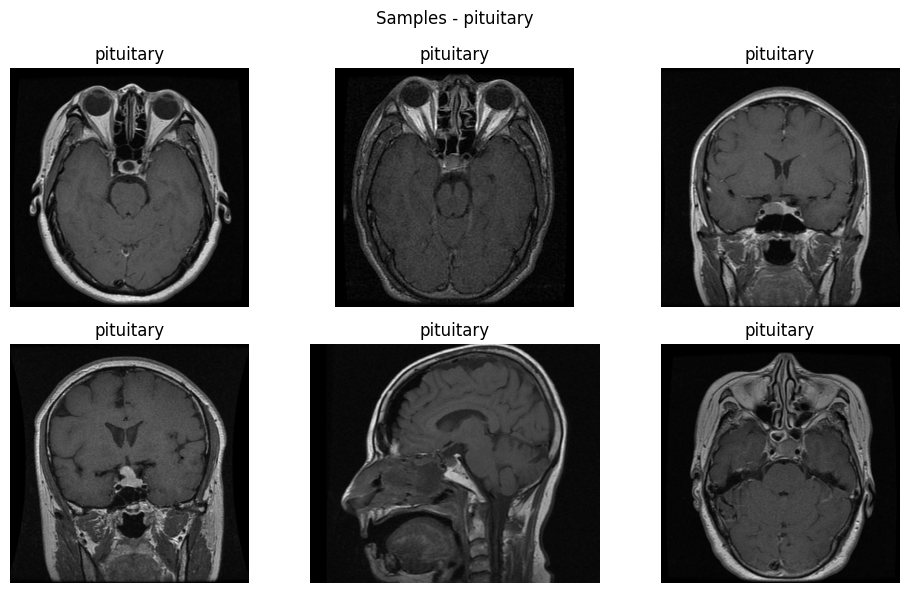

All displayed sample images saved to: eda_outputs\samples


In [13]:
sample_output = os.path.join(OUT_DIR, "samples")
os.makedirs(sample_output, exist_ok=True)

# Analyze image metadata
sample_paths = df_images["path"].sample(min(5249, len(df_images)), random_state=RANDOM_STATE)
dims, modes, corrupt_files = [], Counter(), []

for p in sample_paths:
    try:
        img = Image.open(p)
        img.load()
        dims.append(img.size[::-1])  # (height, width)
        modes[img.mode] += 1
    except Exception as e:
        corrupt_files.append((p, str(e)))

print(f"Color modes: {dict(modes)}")
print(f"Corrupted images: {len(corrupt_files)}\n")

# Display and save sample images per class
classes = df_images["class"].unique()

for c in classes:
    sample = df_images[df_images["class"] == c].sample(
        min(6, len(df_images[df_images["class"] == c])),
        random_state=RANDOM_STATE
    )
    
    # Create directory for class samples
    class_sample_dir = os.path.join(sample_output, c)
    os.makedirs(class_sample_dir, exist_ok=True)
    
    plt.figure(figsize=(10, 6))
    for i, p in enumerate(sample["path"], 1):
        plt.subplot(2, 3, i)
        img = im_read_rgb(p)
        plt.imshow(img)
        plt.axis('off')
        plt.title(c)
        
        # Save each displayed sample
        dest = os.path.join(class_sample_dir, os.path.basename(p))
        if not os.path.exists(dest):
            shutil.copy(p, dest)

    plt.suptitle(f"Samples - {c}")
    plt.tight_layout()
    plt.show()

print(f"All displayed sample images saved to: {sample_output}")


### Class Distribution

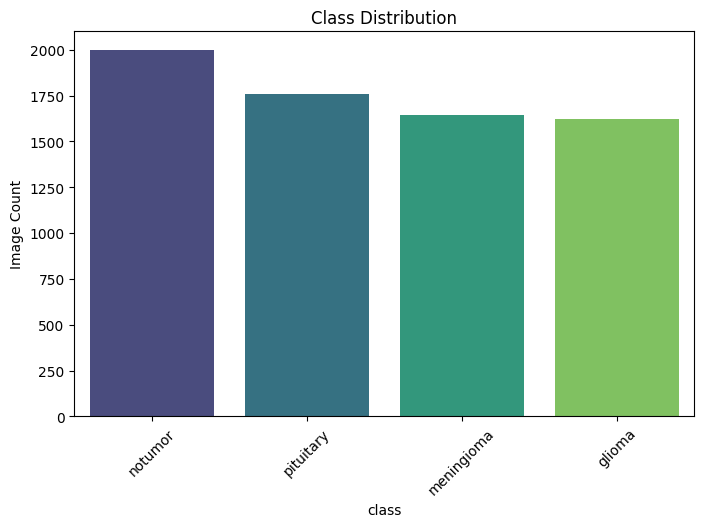

class_distribution.png saved to plots directory.


class
notumor       28.477858
pituitary     25.017799
meningioma    23.423039
glioma        23.081304
Name: proportion, dtype: float64

In [43]:
class_counts = df_images["class"].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.ylabel("Image Count")
plt.savefig(os.path.join(OUT_DIR, "plots", "class_distribution.png"))
plt.show()

print("class_distribution.png saved to plots directory.")

df_images["class"].value_counts(normalize=True) * 100


### Image quality


In [15]:
rows = []
for p, label in zip(df_images["path"], df_images["class"]):
    try:
        img = Image.open(p).convert("L")
        arr = np.array(img)
        mean_int, std_int = arr.mean(), arr.std()
        rms = np.sqrt(np.mean(np.array(ImageStat.Stat(img).var)))
        if cv2 is not None:
            lap_var = cv2.Laplacian(arr, cv2.CV_64F).var()
        else:
            gy, gx = np.gradient(arr.astype(float))
            lap_var = (gx**2 + gy**2).mean()
        if imagehash:
            ah = str(imagehash.average_hash(img))
        else:
            ah = hashlib.md5(ImageOps.fit(img, (64,64)).tobytes()).hexdigest()
        rows.append([p, label, mean_int, std_int, rms, lap_var, ah])
    except:
        pass

df_q = pd.DataFrame(rows, columns=["path","class","mean_intensity","std_intensity","rms_contrast","lap_var","hash"])
df_q.head()


,path,class,mean_intensity,std_intensity,rms_contrast,lap_var,hash
0,mri_dataset\Testing\glioma\Te-glTr_0000.jpg,glioma,30.513634,39.602723,39.602723,90.967606,003c7e7e7e3e3c00
1,mri_dataset\Testing\glioma\Te-glTr_0001.jpg,glioma,23.499611,31.120606,31.120606,39.625153,003c7c7e7e7e3c00
2,mri_dataset\Testing\glioma\Te-glTr_0002.jpg,glioma,17.359077,25.487901,25.487901,15.262497,00183c7e7e7c3c00
3,mri_dataset\Testing\glioma\Te-glTr_0003.jpg,glioma,31.820053,44.951605,44.951605,89.754181,003c7c7e7e7c3c00
4,mri_dataset\Testing\glioma\Te-glTr_0004.jpg,glioma,25.002510,32.717615,32.717615,58.059258,003c7e7e7e7c3c00


### outlier detection

Detected 70 outliers


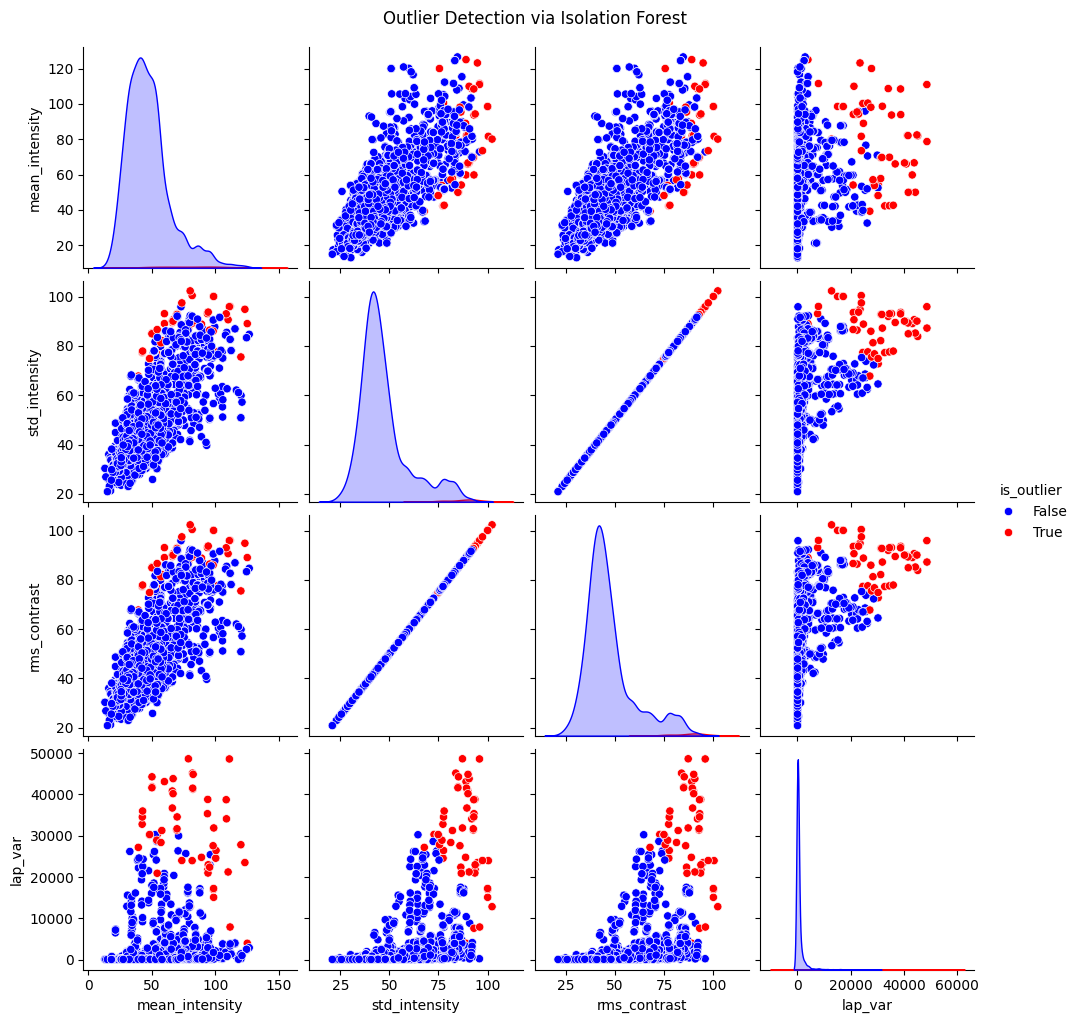

outlier_detection.png saved to plots directory.


In [44]:
features = ["mean_intensity", "std_intensity", "rms_contrast", "lap_var"]
X = StandardScaler().fit_transform(df_q[features].fillna(0))
iso = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
outlier_labels = iso.fit_predict(X)
df_q["is_outlier"] = outlier_labels == -1

print(f"Detected {df_q['is_outlier'].sum()} outliers")

sns.pairplot(df_q.sample(5249), vars=features, hue="is_outlier", palette={False:"blue",True:"red"})
plt.suptitle("Outlier Detection via Isolation Forest", y=1.02)
plt.savefig(os.path.join(OUT_DIR, "plots", "outlier_detection.png"))
plt.show()

print("outlier_detection.png saved to plots directory.")

### tSNE and PCA Plot

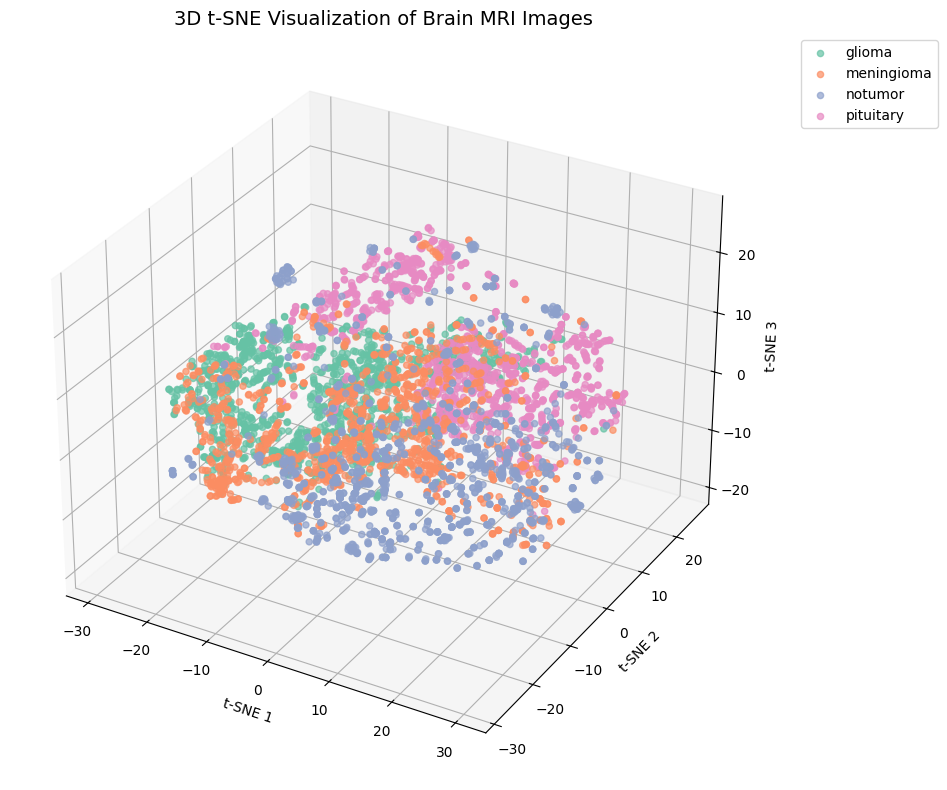

3D t-SNE visualization saved to: eda_outputs\plots\tsne_feature_visualization_3d.png


In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import os
from PIL import Image, ImageOps

# Your preprocessing function
def downsample_flatten(path, size=(64, 64)):
    try:
        im = Image.open(path).convert("L")
        im = ImageOps.fit(im, size)
        return np.array(im).ravel() / 255.0
    except:
        return None

# Sample your images
sample = df_images.sample(min(5249, len(df_images)), random_state=RANDOM_STATE)
X = np.array([downsample_flatten(p) for p in sample["path"] if downsample_flatten(p) is not None])
y = sample["class"].values[:len(X)]

# Dimensionality reduction
pca = PCA(n_components=50, random_state=RANDOM_STATE).fit_transform(X)
tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=1000, random_state=RANDOM_STATE).fit_transform(pca)

# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Map classes to colors
palette = sns.color_palette("Set2", n_colors=len(np.unique(y)))
for i, cls in enumerate(np.unique(y)):
    mask = (y == cls)
    ax.scatter(tsne_3d[mask, 0], tsne_3d[mask, 1], tsne_3d[mask, 2],
               s=20, color=palette[i], label=str(cls), alpha=0.7)

ax.set_title("3D t-SNE Visualization of Brain MRI Images", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save figure
plots_dir = os.path.join(OUT_DIR, "plots")
os.makedirs(plots_dir, exist_ok=True)
plot_path = os.path.join(plots_dir, "tsne_feature_visualization_3d.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")

plt.show()
print(f"3D t-SNE visualization saved to: {plot_path}")


## Deep Learning Model

### Data Augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(DATA_DIR, "Training")
test_dir = os.path.join(DATA_DIR, "Testing")

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

train = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=12
)

val = val_datagen.flow_from_directory(
    train_dir,  
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation', 
)

test = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import numpy as np
from tqdm import tqdm

# CONFIGURATION
input_dir = "mri_dataset/Training"   
output_dir = "augmented"                     # where augmented images are saved
num_augmented_per_image = 5                  # number of augmented images to generate per original image
img_size = (128, 128)                        # resize target

# AUGMENTATION GENERATOR
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# CREATE OUTPUT FOLDERS
os.makedirs(output_dir, exist_ok=True)
for class_name in os.listdir(input_dir):
    class_path = os.path.join(output_dir, class_name)
    os.makedirs(class_path, exist_ok=True)

# APPLY AUGMENTATION
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)

    if not os.path.isdir(class_input_path):
        continue

    image_files = [f for f in os.listdir(class_input_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"\nAugmenting class: {class_name} ({len(image_files)} images)")

    for img_name in tqdm(image_files):
        img_path = os.path.join(class_input_path, img_name)
        img = load_img(img_path, target_size=img_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        prefix = os.path.splitext(img_name)[0]
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=class_output_path,
                                  save_prefix=prefix, save_format="jpg"):
            i += 1
            if i >= num_augmented_per_image:
                break  # stop after desired augmentations
print("\nData augmentation completed successfully!")



Augmenting class: glioma (1321 images)


100%|██████████| 1321/1321 [00:16<00:00, 77.77it/s]



Augmenting class: meningioma (1339 images)


100%|██████████| 1339/1339 [00:17<00:00, 77.95it/s]



Augmenting class: notumor (1595 images)


100%|██████████| 1595/1595 [00:19<00:00, 80.84it/s]



Augmenting class: pituitary (1457 images)


100%|██████████| 1457/1457 [00:18<00:00, 78.02it/s]


Data augmentation completed successfully!


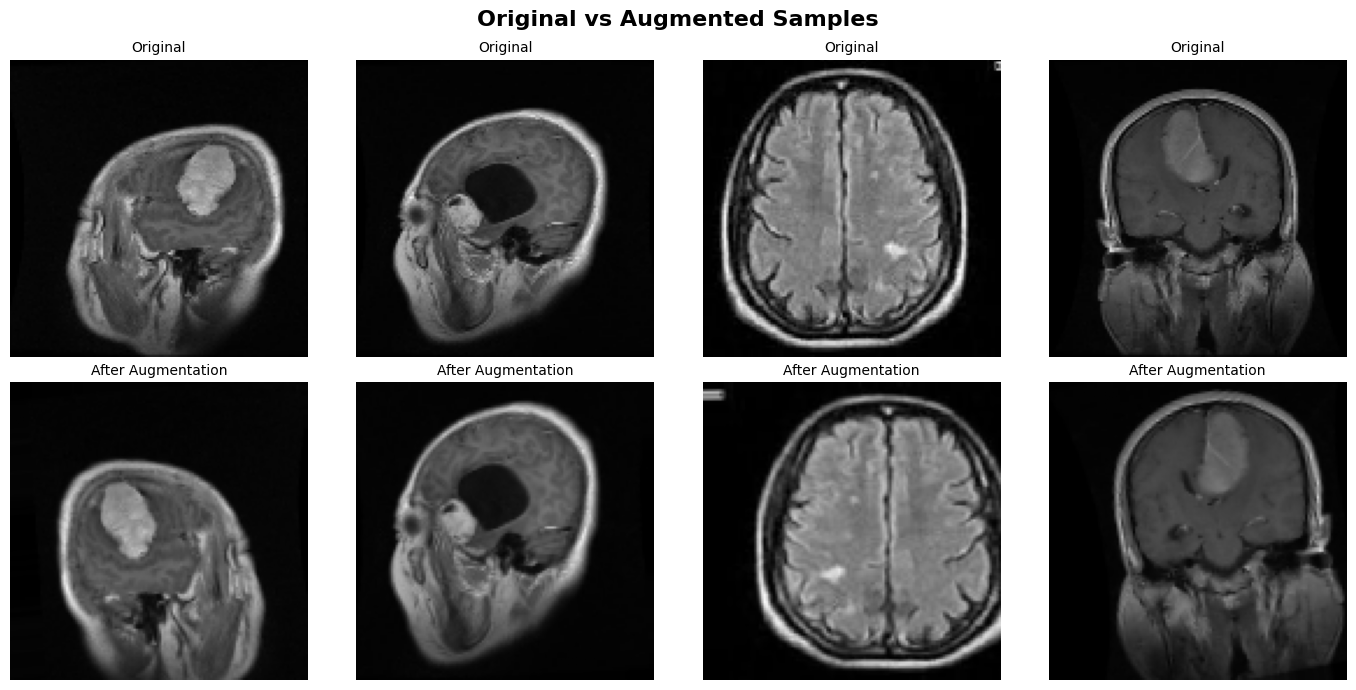

In [32]:
from tensorflow.keras.preprocessing import image
import random
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle("Original vs Augmented Samples", fontsize=16, fontweight='bold')

# pick random 4 image paths from training generator
sample_paths = random.sample(train.filepaths, 4)

for i, img_path in enumerate(sample_paths):
    # Load and prepare image
    original_img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(original_img)
    x = np.expand_dims(x, axis=0)

    # Generate augmented version
    aug_iter = datagen.flow(x, batch_size=1)
    augmented_img = next(aug_iter)[0]

    # Normalize for display (clip to [0,1])
    augmented_img = np.clip(augmented_img / 255.0, 0, 1)

    # Display original
    axes[0, i].imshow(original_img)
    axes[0, i].set_title("Original", fontsize=10)
    axes[0, i].axis('off')

    # Display augmented
    axes[1, i].imshow(augmented_img)
    axes[1, i].set_title("After Augmentation", fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "plots", "augmentation_samples.png"), dpi=300)
plt.show()


## CNN Model Training

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential([
    
    Conv2D(64, (3,3), activation='relu', input_shape=(128,128,3),padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(128, (3,3), activation='relu',padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(256, (3,3), activation='relu',padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    
    Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,215,108 (65.67 MB)

 Trainable params: 17,215,108 (65.67 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,          
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=3,           
    min_lr=1e-4,          
    verbose=1            
)

history = model.fit(
    train,
    validation_data=val,
    epochs=40,
    callbacks=[early_stop, lr_scheduler],
)

best_epoch = early_stop.stopped_epoch - early_stop.patience + 1

best_acc = history.history['accuracy'][best_epoch - 1]
best_val_acc = history.history['val_accuracy'][best_epoch - 1]

print(f"Best epoch (chosen by EarlyStopping): {best_epoch}")
print(f"Training accuracy at best epoch: {best_acc:.4f}")
print(f"Validation accuracy at best epoch: {best_val_acc:.4f}")

Epoch 1/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 49s 310ms/step - accuracy: 0.5839 - loss: 1.4442 - val_accuracy: 0.7392 - val_loss: 1.0654 - learning_rate: 0.0010
Epoch 2/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - accuracy: 0.7610 - loss: 0.8840 - val_accuracy: 0.7602 - val_loss: 0.9182 - learning_rate: 0.0010
Epoch 3/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 308ms/step - accuracy: 0.7976 - loss: 0.7626 - val_accuracy: 0.7778 - val_loss: 0.8267 - learning_rate: 0.0010
Epoch 4/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - accuracy: 0.8221 - loss: 0.7081 - val_accuracy: 0.7848 - val_loss: 0.8592 - learning_rate: 0.0010
Epoch 5/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.8382 - loss: 0.6795 - val_accuracy: 0.6725 - val_loss: 1.1915 - learning_rate: 0.0010
Epoch 6/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.8378 - loss: 0.6969 - val_accuracy: 0.8047 - val_loss: 0.7805 - learning_rate: 0.0010
Epoch 7/40
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 362ms/step - accuracy: 0.8

## Training and Validation Accuracy and Loss Plots

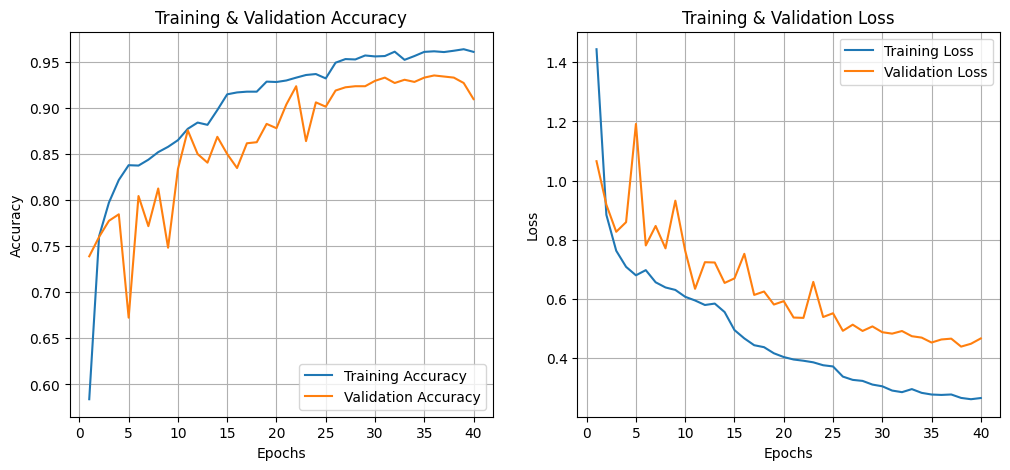

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(epochs, acc, label='Training Accuracy')
ax1.plot(epochs, val_acc, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training & Validation Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training & Validation Loss')
ax2.legend()
ax2.grid(True)

plt.savefig(os.path.join(OUT_DIR, "plots", "training_validation_metrics.png"), dpi=300)
plt.show()

In [37]:
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.9580 - loss: 0.3030
Test Accuracy: 95.80%
Test Loss: 0.3030


## Confusion Matrix and Error Analysis

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.92      0.95       300
  meningioma       0.91      0.92      0.91       306
     notumor       0.96      0.99      0.97       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



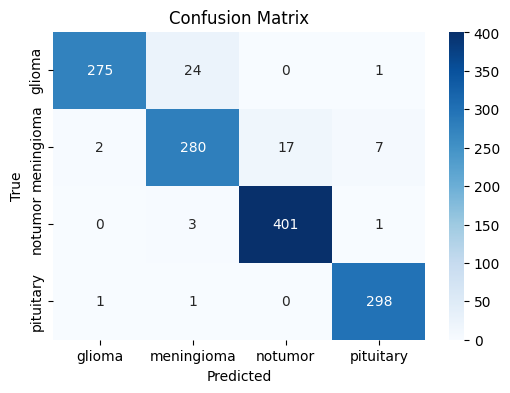

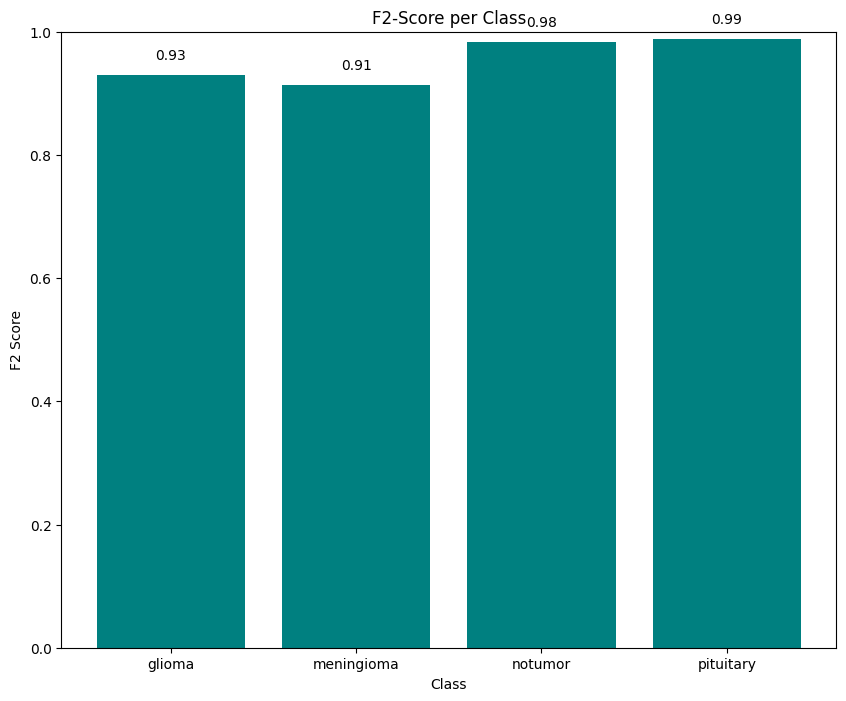

Weighted F2 Score: 0.9564
Total misclassified images: 57
Misclassified images saved in 'misclassified_samples' directory.


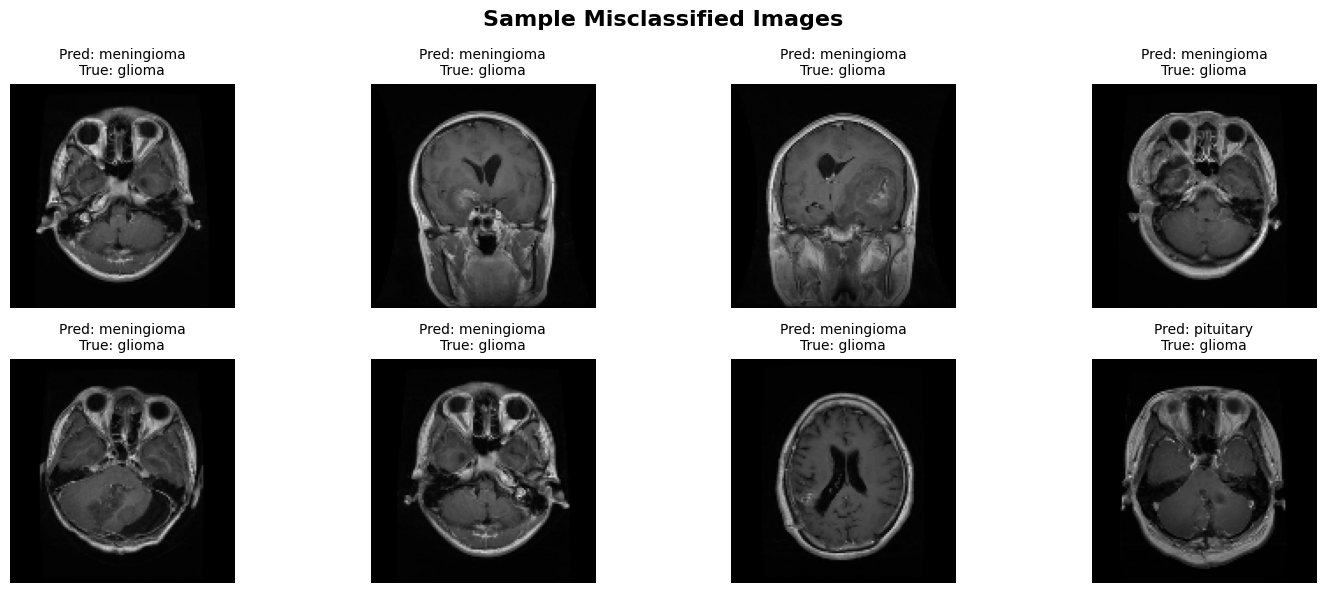

misclassified_samples.png saved to plots directory.


In [55]:
# Predictions and true labels
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test.classes
class_labels = list(test.class_indices.keys())

# Classification report and confusion matrix
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUT_DIR, "plots", "confusion_matrix.png"), dpi=300)
plt.show()

# Compute F2-score per class
f2_scores = fbeta_score(y_true, y_pred_classes, beta=2, average=None)

# Plot F2-score per class
plt.figure(figsize=(10, 8))
bars = plt.bar(class_labels, f2_scores, color='teal')
plt.title('F2-Score per Class')
plt.ylabel('F2 Score')
plt.xlabel('Class')
plt.ylim(0, 1)

# Annotate bars with values
for bar, score in zip(bars, f2_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{score:.2f}", ha='center', va='bottom', fontsize=10)
plt.savefig(os.path.join(OUT_DIR, "plots", "f2_score_per_class.png"), dpi=300)
plt.show()

# Weighted (overall) F2-score
weighted_f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')
print(f"Weighted F2 Score: {weighted_f2:.4f}")


# Identify misclassified indices
misclassified_indices = np.where(y_true != y_pred_classes)[0]
print(f"Total misclassified images: {len(misclassified_indices)}")

# Save misclassified images
for i, idx in enumerate(misclassified_indices):
    img_path = test.filepaths[idx]
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred_classes[idx]]
    
    # Create a subdirectory for each true label
    subdir = os.path.join(output_dir, true_label)
    os.makedirs(subdir, exist_ok=True)
    
    # Copy the image to the misclassified folder
    filename = f"{i+1}_{os.path.basename(img_path).split('.')[0]}_pred-{pred_label}_true-{true_label}.jpg"
    shutil.copy(img_path, os.path.join(subdir, filename))

print(f"Misclassified images saved in '{output_dir}' directory.")

# Display some misclassified samples
n_display = min(8, len(misclassified_indices))
if n_display > 0:
    fig, axes = plt.subplots(2, n_display // 2, figsize=(15, 6))
    fig.suptitle("Sample Misclassified Images", fontsize=16, fontweight='bold')
    for i, idx in enumerate(misclassified_indices[:n_display]):
        img = image.load_img(test.filepaths[idx], target_size=(128, 128))
        ax = axes[i // (n_display // 2), i % (n_display // 2)]
        ax.imshow(img)
        ax.axis('off')
        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred_classes[idx]]
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "plots", "misclassified_samples.png"), dpi=300)
    plt.show()

print("misclassified_samples.png saved to plots directory.")

In [41]:
model.save('brain_tumor.keras')